### 문제 정의 (목표 설정)
- 타이타닉 데이터를 학습해서 생존자와 사망자를 예측해보자.
- 머신러닝의 전체 과정을 진행해보면서 프로세스를 이해해보자

In [71]:
# 필요한 라이브러리 import 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

### 데이터 수집(Kaggle 사이트에서 다운로드)

In [72]:
# 데이터 불러오기 - 기존 PassengerId 컬럼을 인덱스로 설정
train = pd.read_csv('./data/train.csv', index_col='PassengerId')
test = pd.read_csv('./data/test.csv', index_col='PassengerId')

In [73]:
# 데이터 확인
print(train.shape)
print(test.shape)

(891, 11)
(418, 10)


In [74]:
# test에 대한 정답은 kaggle이 가지고 있음
# 우리는 test 데이터로 예측을 진행해서 Kaggle에 제출해야 한다.

**타이타닉 데이터의 구조**
- 3개의 파일로 이루어져 있다.
- train.csv : 학습용 / 훈련용 데이터
- test.csv : 평가용 데이터
- gender_submission.csv : 제출용 답안지 서식 파일

In [75]:
# 데이터 컬럼 확인
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [76]:
test.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')

**타이타닉 데이터 내부의 컬럼 정보**
- 'PassengerId' : 승객의 번호
- 'Survived' : 생존여부(0,1) / train에만 존재
- 'Pclass' : 승객의 등급(1~3)
- 'Name' : 승객 이름
- 'Sex' : 승객 성별
- 'Age' : 승객 나이
- 'SibSp' : 동승한 형제 또는 배우자의 수
- 'Parch' : 동승한 부모 또는 자녀의 수
- 'Ticket' : 티켓 번호
- 'Fare' : 승객이 지불한 요금
- 'Cabin' : 객실의 번호
- 'Embarked' : 승선지(C : 쉘부르크(셰르부르) / Q : 퀸즈타운 / S : 사우스햄튼)

In [77]:
# 데이터프레임에 대한 간략한 정보
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [78]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


**결측치 정리**
- train : Age / Cabin / Embarked
- test : Age / Fare / Cabin

### 데이터 전처리

Age 살펴보기

In [79]:
train['Age']

PassengerId
1      22.0
2      38.0
3      26.0
4      35.0
5      35.0
       ... 
887    27.0
888    19.0
889     NaN
890    26.0
891    32.0
Name: Age, Length: 891, dtype: float64

In [80]:
test['Age']

PassengerId
892     34.5
893     47.0
894     62.0
895     27.0
896     22.0
        ... 
1305     NaN
1306    39.0
1307    38.5
1308     NaN
1309     NaN
Name: Age, Length: 418, dtype: float64

In [81]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [82]:
test['Age'].describe()

count    332.000000
mean      30.272590
std       14.181209
min        0.170000
25%       21.000000
50%       27.000000
75%       39.000000
max       76.000000
Name: Age, dtype: float64

**Age 컬럼의 특성**
- 타입은 실수형
- 나이 데이터는 최소값 쪽으로 쏠린 모습을 보인다.(분포가 치우쳐져 있다.)
- 0 ~ 80 까지의 데이터를 가지고 있다. -> 일반적인 평균을 구하기엔 범위가 넓다.
- 다른 컬럼과 상관관계를 살펴보고 연관성 있는 컬럼을 엮어서 상세하게 결측치를 채워보자

In [83]:
# 상관관계 : 각 특성별로 영향도를 수치로 파악할 수 있다.
# 절대값이 클수록 영향도가 높다.
train.corr() # 수치형 데이터만 나온다

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [84]:
# 상관관계가 높은 데이터를 가지고 피봇테이블을 만들어보자
pt1 = train.pivot_table(values='Age', # 데이터로 사용할 데이터 지정
                       index=['Pclass', 'Sex'], # 인덱스를 설정하겠다(멀티 인덱스)
                        # 생존 여부에 영향을 많이 미치는 성별도 추가
                        # 인덱스를 설정할 때 1차로 Pclass로 나눈 뒤 성별로 한번 더 나눔
                        aggfunc='mean' # 데이터 요약시 사용하는 함수를 지정
                        # (mean / sum / count)
                       )
pt1

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000
       male    26.507589

- 나이가 많을수록 등급 숫자가 낮아진다?

In [85]:
# 멀티 인덱스 인덱싱
pt1.loc[1, 'male']

Age    41.281386
Name: (1, male), dtype: float64

In [86]:
# 결측치 확인 - pd.isna()
pd.isna(train['Age'])

PassengerId
1      False
2      False
3      False
4      False
5      False
       ...  
887    False
888    False
889     True
890    False
891    False
Name: Age, Length: 891, dtype: bool

In [87]:
# 불리언 인덱싱으로 확인해보기
train[pd.isna(train['Age'])]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...
860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S


- 177개에 대한 데이터의 조건을 맞춰서 나이값을 넣어주기 어렵다.
- apply 함수를 이용해서 한번에 값을 처리해주겠다.
- apply() : 다른 함수를 pandas의 객체에 연결시켜주는 함수

In [88]:
# 나이를 채워주는 함수를 만들어보자.
def fill_age(data) : # 매개변수 data에는 train 또는 test 데이터가 들어가게 된다
    # 만약 data에 Age컬럼이 결측치라면 피봇테이블에서 값을 가져와 넣어줘라
    if pd.isna(data['Age']) :
    # 위에서 만든 피봇 테이블 멀티 인덱싱한 값을 리턴
        return pt1.loc[data['Pclass'], data['Sex']]
    # Age 컬럼의 결측치가 없다면 기존의 값을 사용
    else :
        return data['Age']

In [89]:
# Age 결측치 채우기
train['Age'] = train.apply(fill_age, axis = 1).astype('int64')

In [90]:
test['Age'] = test.apply(fill_age, axis = 1).astype('int64')

In [91]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 83.5+ KB


In [92]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    int64  
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 35.9+ KB


In [93]:
train['Age'].describe()

count    891.000000
mean      29.191919
std       13.313598
min        0.000000
25%       21.000000
50%       26.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64

- Age 결측치 모두 채우기 완료
- 상관관계를 이용해서 나이 데이터를 채워줬다!

**Embarked 데이터 채워주기**
- 결측치 2개있다.

In [94]:
# Embarked 내부 데이터의 구조는?
# Q / S / T 3가지 값으로 구분이 되어있음
# 각각의 갯수를 살펴보자. - 데이터의 분포를 살펴보자
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [95]:
# 결측치를 채워주는 함수 : fillna()
train['Embarked'] = train['Embarked'].fillna('S')

In [96]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 83.5+ KB


**Fare 채워주기**
- test에 결측치가 있다

In [97]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    int64  
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 35.9+ KB


In [98]:
# Fare에 대한 기술 통계 살펴보기
test['Fare'].describe()

count    417.000000
mean      35.627188
std       55.907576
min        0.000000
25%        7.895800
50%       14.454200
75%       31.500000
max      512.329200
Name: Fare, dtype: float64

- Fare 컬럼은 최대 / 최소값을 봤을 때 편차가 크고 평균과 사분위수가 한쪽으로 쏠려있다.
- 전체 금액을 가지고 평균을 구하면 신뢰성이 많이 떨어질 것 같다.

In [99]:
# 상관계수 살펴보기 - train
train.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.066538,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.410104,0.083081,0.018443,-0.549500
Age,-0.066538,-0.410104,1.000000,-0.251439,-0.178855,0.120173
SibSp,-0.035322,0.083081,-0.251439,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.178855,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.120173,0.159651,0.216225,1.000000


In [100]:
# 피봇 테이블 만들어보기[연관관계가 높은 컬럼, 성별], 금액은 평균을 구해볼거임 - train
pt2 = train.pivot_table(values='Fare', index=['Pclass', 'Sex'], aggfunc='mean')
pt2

Fare
Pclass Sex               
1      female  106.125798
       male     67.226127
2      female   21.970121
       male     19.741782
3      female   16.118810
       male     12.661633

In [101]:
# test['Fare']의 비어있는 곳 찾기
# 불리언 인덱싱으로 값을 가져와보자
test[test['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60,0,0,3701,NaN,NaN,S


In [102]:
# fillna() 함수 이용해서 값을 채워주자
test['Fare'] = test['Fare'].fillna(12.661633)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    int64  
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 35.9+ KB


In [103]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 83.5+ KB


**Cabin 채워주기**
- train / test 모두 결측치가 많다.(이럴 경우 컬럼을 삭제하는 것도 고려한다.)
- 일단은 결측치에 임의의 값을 넣어보고 시각화까지 해서 사용여부를 판단하자

In [104]:
train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

- 데이터의 모양이 알파벳과 숫자 순으로 이뤄졌다
- 여러 개가 묶인 데이터는 모두 같은 알파벳을 사용한다.
- 타이타닉 호의 단면도와 정보를 찾아보니 알파벳은 층수 / 숫자는 방 번호를 이야기한다.
- 알파벳을 가지고 와서 층수 정보를 활용할 수 있다.

In [105]:
train['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

- 데이터의 고유값이 너무 많다(데이터가 넓고 얕게 분포되어 있다.)
- 알파벳만 빼와서 사용하면 어떤 형태가 되는지 살펴 보자

In [106]:
# 우선 결측치부터 채우고 시작하자
# 임의의 문자 M을 넣어서 채워주고 Deck컬럼을 생성하자
train['Deck'] = train['Cabin'].fillna('M')
test['Deck'] = test['Cabin'].fillna('M')

In [107]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
 11  Deck      891 non-null    object 
dtypes: float64(1), int64(5), object(6)
memory usage: 90.5+ KB


In [108]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    int64  
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
 10  Deck      418 non-null    object 
dtypes: float64(1), int64(4), object(6)
memory usage: 39.2+ KB


In [109]:
# Deck 컬럼에서 맨 앞 영문자만 따오자
train['Deck'] = train['Deck'].str[0]
test['Deck'] = test['Deck'].str[0]

In [110]:
train['Deck'], test['Deck']

(PassengerId
 1      M
 2      C
 3      M
 4      C
 5      M
       ..
 887    M
 888    B
 889    M
 890    C
 891    M
 Name: Deck, Length: 891, dtype: object,
 PassengerId
 892     M
 893     M
 894     M
 895     M
 896     M
        ..
 1305    M
 1306    C
 1307    M
 1308    M
 1309    M
 Name: Deck, Length: 418, dtype: object)

In [111]:
# train / test info() 확인 - 데이터 소실된게 있는지
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
 11  Deck      891 non-null    object 
dtypes: float64(1), int64(5), object(6)
memory usage: 90.5+ KB


In [112]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    int64  
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
 10  Deck      418 non-null    object 
dtypes: float64(1), int64(4), object(6)
memory usage: 39.2+ KB


### 탐색적 데이터 분석(EDA)

**Deck 컬럼 살펴보기**

In [113]:
# groupby : 그룹별로 데이터를 집계 요약해주는 함수
train_deck = train[['Deck', 'Survived', 'Name']].groupby(['Deck', 'Survived']).count()
train_deck

Name
Deck Survived      
A    0            8
     1            7
B    0           12
     1           35
C    0           24
     1           35
D    0            8
     1           25
E    0            8
     1           24
F    0            5
     1            8
G    0            2
     1            2
M    0          481
     1          206
T    0            1

<AxesSubplot:xlabel='Deck', ylabel='count'>

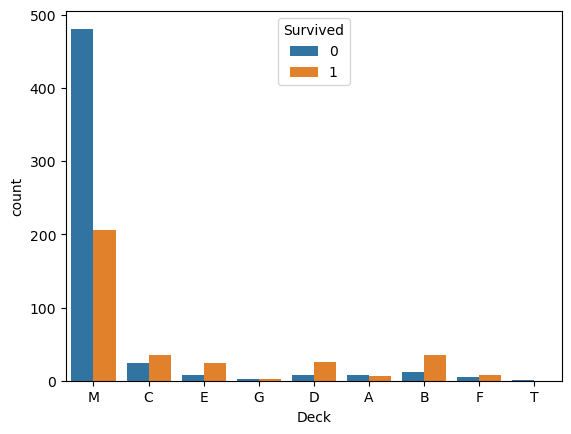

In [114]:
# seaborn 라이브러리를 이용해서 시각화를 진행해보자
sns.countplot(data=train,
             x='Deck',
             hue='Survived')

 - M이라는 곳에서 상대적으로 사람이 많이 죽었네(결측치 있는 부분)

**Pclass 살펴보기

<AxesSubplot:xlabel='Pclass', ylabel='count'>

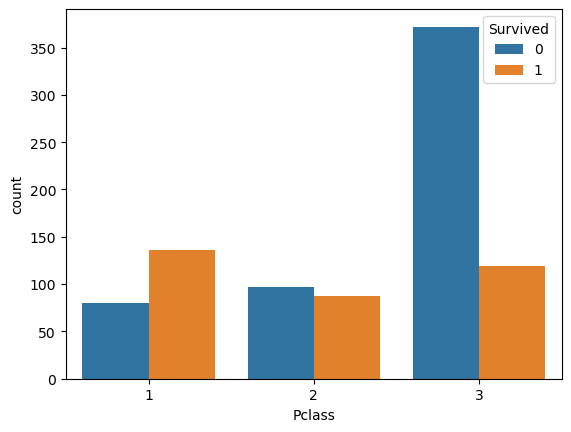

In [115]:
sns.countplot(data=train,
             x='Pclass',
             hue='Survived')

- 1등급의 사람이 많이 살았고 3등급의 사람이 많이 죽었다.

**Deck과 Pclass를 동시에 시각화해보자

<AxesSubplot:xlabel='Deck', ylabel='count'>

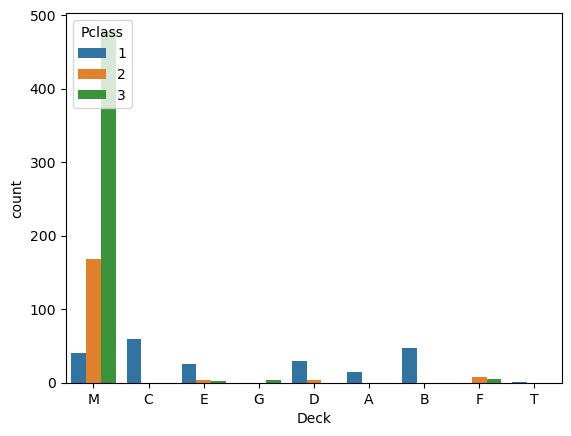

In [116]:
sns.countplot(data=train,
             x='Deck',
             hue='Pclass')

- Deck이 'M'인 데이터(결측치인 부분)에는 3등급 사람이 많았다
- 3등급의 사람들이 생존율이 낮았다
- 당연히 Deck이 'M'인 사람들도 생존율이 낮을 수밖에 없다.

<AxesSubplot:xlabel='Sex', ylabel='count'>

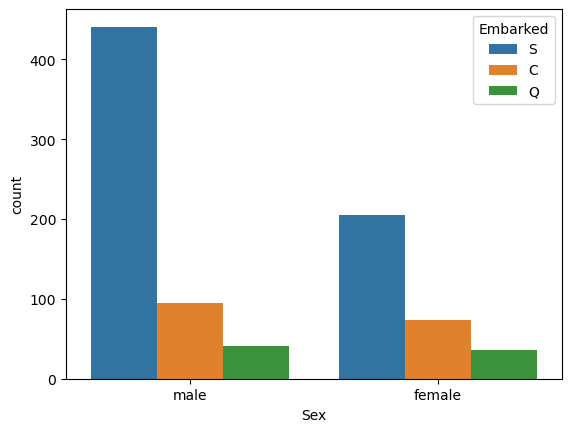

In [117]:
# 성별과 승선지를 시각화
sns.countplot(data=train, x='Sex', hue='Embarked')

- 남자, 여자 모두 S에서 가장 많이 탔고 Q에서 가장 적게 승선했다

<AxesSubplot:xlabel='Embarked', ylabel='count'>

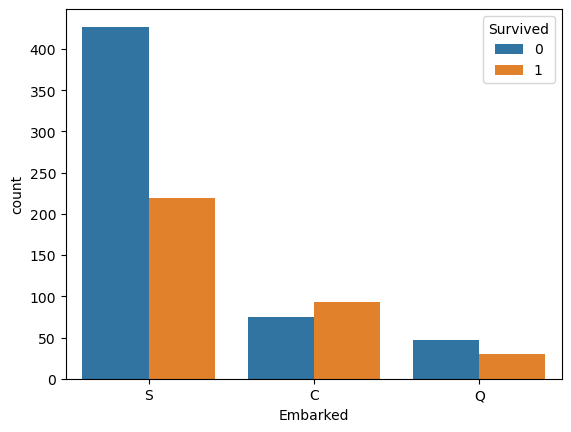

In [118]:
# 승선지와 생존율을 시각화
sns.countplot(data=train, x='Embarked', hue='Survived')

- C를 제외하고는 모든 승선지의 사람들은 산사람보다 죽은 사람이 더 많다
- S에서 승선한 사람이 가장 많이 죽었는데 S에서 승선한 인원이 많아서 어쩔 수 없어 보임

<AxesSubplot:xlabel='Sex', ylabel='count'>

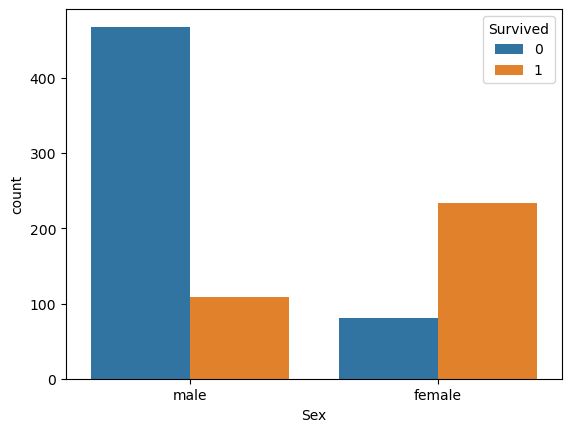

In [119]:
# 성별과 생존 시각화
sns.countplot(data=train, x='Sex', hue='Survived')

- 여자보단 남자가 사망비율이 더 높다
- 남녀가 평등하지 않다

<AxesSubplot:xlabel='Pclass', ylabel='count'>

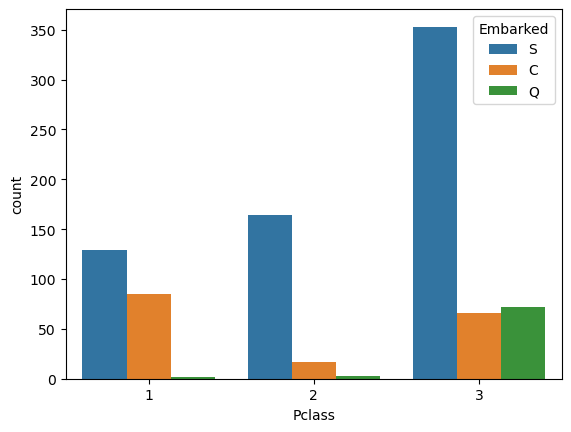

In [120]:
# 승객등급과 승선지를 시각화
sns.countplot(data=train, x='Pclass', hue='Embarked')

- 3등급에 사우스햄튼 탑승자가 많다. 
- 모든 등급의 사람들이 S 승선지에서 가장 많이 승선했다.

<AxesSubplot:xlabel='Deck', ylabel='count'>

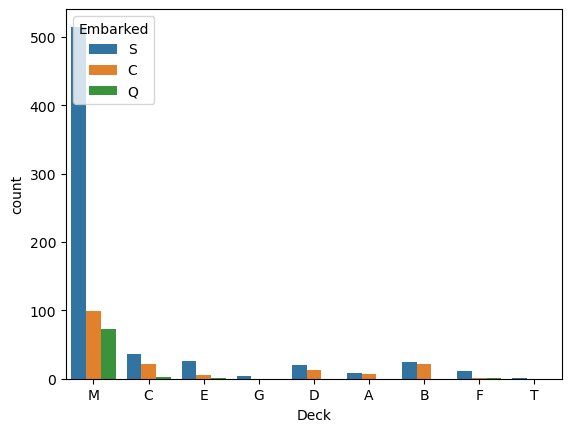

In [121]:
# Deck과 승선지를 시각화 해보자
sns.countplot(data=train, x='Deck', hue='Embarked')


- Deck이 M인 사람은 사우스햄튼에서 많이 탔다.
- 모든 층의 사람들이 S승선지에서 가장 많이 승선했다.

**Age 컬럼 시각화**

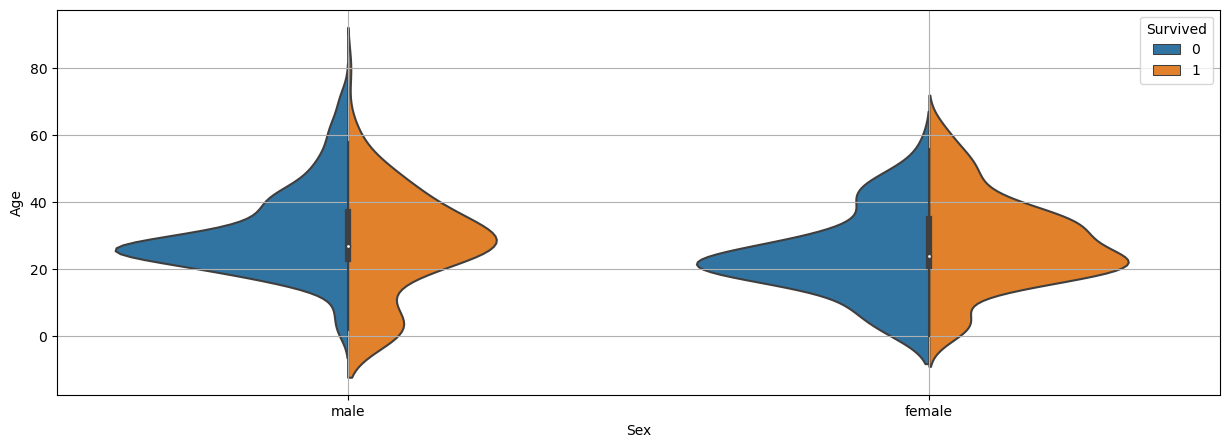

In [122]:
plt.figure(figsize=(15,5))
# 바이올린 플롯 : 바이올린의 모양으로 데이터의 분포와 밀도를 보기 쉽게 나타낸 차트  
# 데이터가 많은 부분은 두께가 두껍게 / 작게 분포하는 부분은 얇게 나타냄  

sns.violinplot(data = train,
              x = 'Sex',
              y = 'Age',
              hue = 'Survived',
              split=True)

plt.grid()

# 가운데 하얀색 점 : 중앙값
# 바이올린 내부의 두꺼운 선 : 사분위수의 범위
# 바이올린 내부의 얇은 선 : 신뢰구간(95%  정도의 신뢰성이 있는 데이터다! 라는걸 표현)

# 수치형 데이터는 연속적인 값을 가지고 있다. 그래서 유니크 값이 많으면 막대그래프의 
# 막대가 많아진다.(보기 어려워진다.)
# 연속된 데이터를 시각화 할때는 곡선형 그래프를 많이 이용한다.




- 20 대에서 40대가 많이 죽었다 / 전체적인 탑승자도 많았구나.
- 나이 많은 사람들의 생존율이 높다.  
- 20세 이하 미성년자는 남자의 생존 비율이 더 높다 

**Fare 살펴보기**

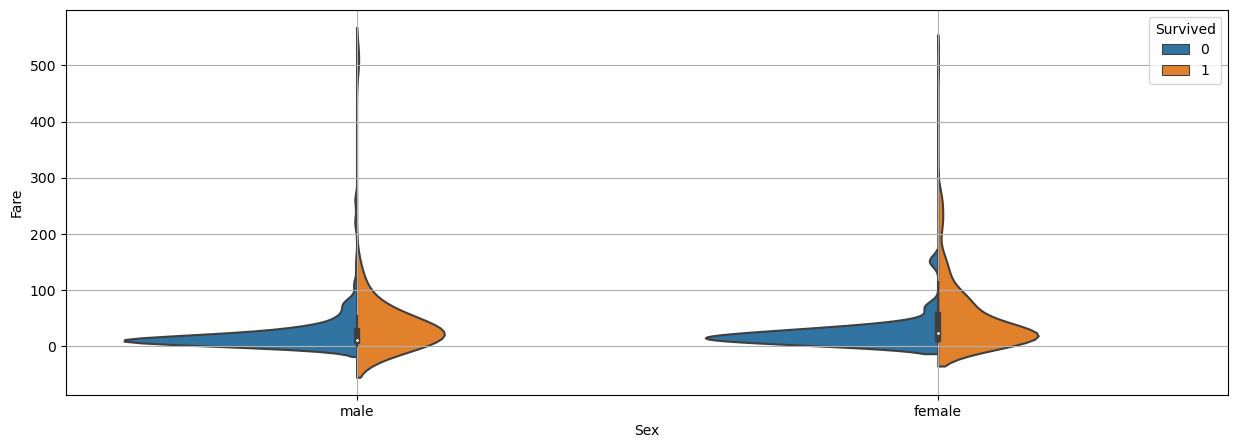

In [123]:
plt.figure(figsize=(15,5))
# 바이올린 플롯 : 바이올린의 모양으로 데이터의 분포와 밀도를 보기 쉽게 나타낸 차트  
# 데이터가 많은 부분은 두께가 두껍게 / 작게 분포하는 부분은 얇게 나타냄  

sns.violinplot(data = train,
              x = 'Sex',
              y = 'Fare',
              hue = 'Survived',
              split=True)

plt.grid()

### SibSp, Parch 살펴보기
- SibSp : 함께 탑승한 형제/자매/배우자
- Parch : 함께 탑승한 부모/ 자식

**모두 합쳐서 가족으로 만들어도 되지 않을까**


In [124]:
# 컬럼 추가  
train['Family_Size'] = train['Parch'] + train['SibSp'] + 1
test['Family_Size'] = test['Parch'] + test['SibSp'] + 1

<AxesSubplot:xlabel='Family_Size', ylabel='count'>

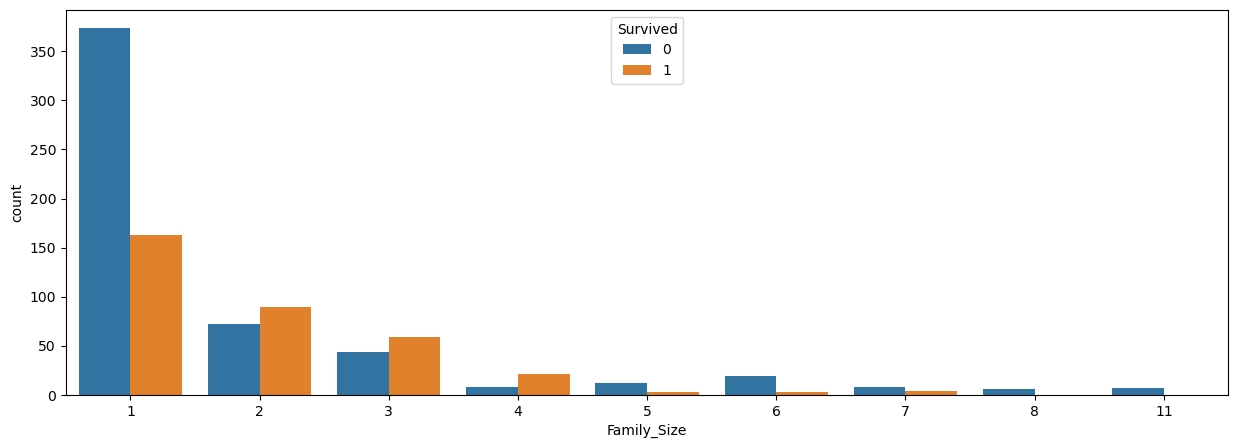

In [125]:
plt.figure(figsize=(15,5))
# 바이올린 플롯 : 바이올린의 모양으로 데이터의 분포와 밀도를 보기 쉽게 나타낸 차트  
# 데이터가 많은 부분은 두께가 두껍게 / 작게 분포하는 부분은 얇게 나타냄  



sns.countplot(data = train,
              x = 'Family_Size',
              hue = 'Survived',
              )



- 혼자 왔을때 많이 죽었다
- 가족이 2~4 명 사이일때 생존율이 올라갔다
- 5명 이상일때는 사망율이 올라갔다  


In [126]:
# 가족사이즈가 1이면 Alone  / 2~4 small / 5명 이상이면 Large
# 전체 가족의 숫자를 범주화 시켜서 Family_Group 이라는 컬럼을 생성
######################################################################## Binning : 수치형 데이터를 범주형 데이터로 바꿔주는 작업
# 사소한 관찰의 오류를 줄여주기 위해 실행하는 방법
#######################################################################  Binning <--> encoding   인코딩 --범주형을 수치형으로
bins = [0, 1, 4, 11]
labels = ['Alone', 'Small','Large']

train['Family_Group'] = pd.cut(train['Family_Size'],
                              bins = bins,
                              labels = labels)
test['Family_Group'] = pd.cut(test['Family_Size'],
                              bins = bins,
                              labels = labels)

<AxesSubplot:xlabel='Family_Group', ylabel='count'>

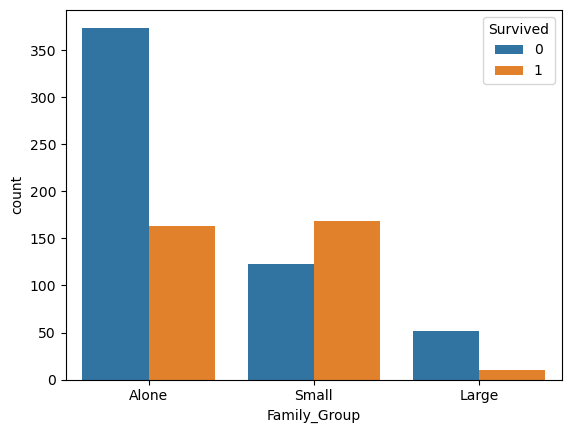

In [127]:
sns.countplot(data=train,
             x='Family_Group',
             hue='Survived',
             )





### Name 다뤄보기
- 텍스트 데이터인 Name을 다뤄보자

In [128]:
train['Name']
# 너무 많은 이름

PassengerId
1                                Braund, Mr. Owen Harris
2      Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                 Heikkinen, Miss. Laina
4           Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                               Allen, Mr. William Henry
                             ...                        
887                                Montvila, Rev. Juozas
888                         Graham, Miss. Margaret Edith
889             Johnston, Miss. Catherine Helen "Carrie"
890                                Behr, Mr. Karl Howell
891                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [129]:
train['Name'].unique()
len(train['Name'].unique())

891

- 중간 호칭으로 직업을 알수있다.
- 외국의 이름은 미들네임(중간 호칭)이 있다.
- 미들네임은 성별 / 결혼 유무 / 신분 /직업을 표시해주는 부분이다. 
- 미들네임만 추출해서 사용해보자  

In [130]:
train['Name'][1]

'Braund, Mr. Owen Harris'

In [131]:
train['Name'][1].split(',')[1].split('.')[0]

' Mr'

In [132]:
# strip() : 특정 문자열의 최선두와 최후미 공백 제거
train['Name'][1].split(',')[1].split('.')[0].strip()

'Mr'

In [133]:
# 이름을 쪼개주는 함수를 만들자!
def split_title(data) : 
    result = data.split(',')[1].split('.')[0].strip()
    return result

In [134]:
train['Title'] = train['Name'].apply(split_title)
test['Title'] = test['Name'].apply(split_title)

# train.apply였다면 2차원 데이터프레임이 들어가서 축설정이 필요했다(axis 가 필요했다)
# train['Name'].apply 였다면 1차원 시리즈가 들어가서 축설정이 필요없다(axis가 필요없다)

In [65]:
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [136]:
test['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [137]:
test[test['Title'] == 'Dona']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Family_Size,Family_Group,Title
PassengerId,,,,,,,,,,,,,,
1306,1,"Oliva y Ocana, Dona. Fermina",female,39,0,0,PC 17758,108.9,C105,C,C,1,Alone,Dona


<AxesSubplot:xlabel='Title', ylabel='count'>

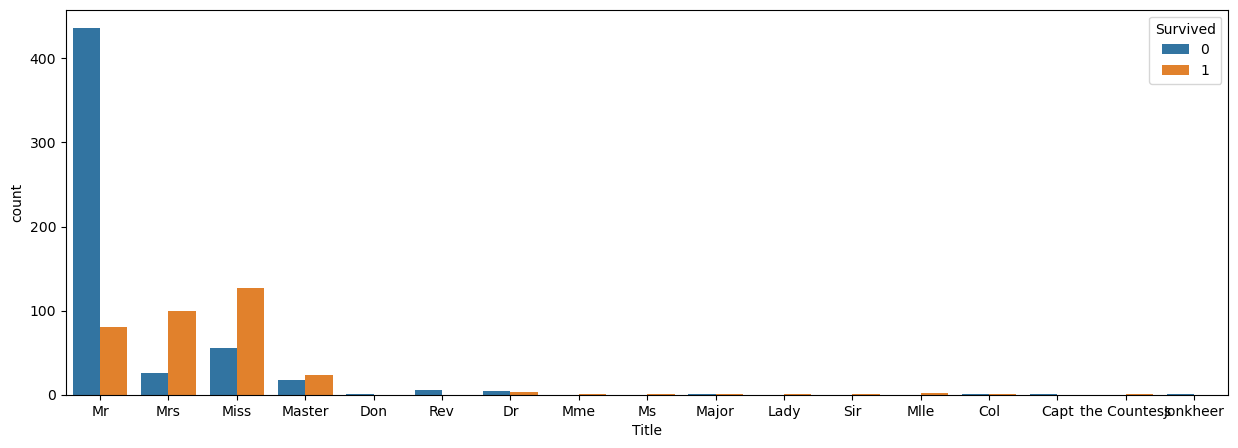

In [138]:
plt.figure(figsize=(15,5))

sns.countplot(data=train,
             x='Title',
             hue='Survived')

- Title의 호칭 정리

- 'Mr'
- 'Mrs'
- 'Miss' 
- 'Master' = 미성년자 남성
- 'Don' = 일반적 남자 부르는 호칭
- 'Rev' = 목사님
- 'Dr' = 의사
- 'Mme' = 기혼 여성을 높여 부르는 말
- 'Ms' = 결혼 여부와 산관없이 여성
- 'Major' = 소령 / 시장
- 'Lady' = 아가씨
- 'Sir' = 기사
- 'Mlle' = 마드 모아젤 / 프랑스에서 미혼 여성 일반적으로 붙는 호칭
- 'Col' = 육군 대령 / 미국 남부에서는 신사
- 'Capt' = 선장 / 대위
- 'the Countess' =  주지사
- 'Jonkheer' = 작위가 없는 무명 귀족

- Mr, Mrs, Miss, Master, Rev를 제외한 모든 호칭은 상대적으로 갯수가 적으니까 Other라고 묶어서 활용해보자

In [139]:
# train['Title']의 unique 값을 그대로 복사해와서 title이라는 리스트에 담아주기

# Don / Rev라는 호칭의 순서를 바꿔주자(zip함수를 사용할때 순서를 맞춰주기 위해서)

title=['Mr', 'Mrs', 'Miss', 'Master', 'Rev', 'Don', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer']
title

['Mr',
 'Mrs',
 'Miss',
 'Master',
 'Rev',
 'Don',
 'Dr',
 'Mme',
 'Ms',
 'Major',
 'Lady',
 'Sir',
 'Mlle',
 'Col',
 'Capt',
 'the Countess',
 'Jonkheer']

In [140]:
convert_title = ['Mr', 'Mrs', 'Miss', 'Master', 'Rev'] + ['Other']*12
convert_title

['Mr',
 'Mrs',
 'Miss',
 'Master',
 'Rev',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other']

In [141]:
# dict(zip()) 함수를 이용해서 리스트형태인 title과 convert_title을 차례대로
# key와 value로 가지는 딕셔너리호 만들겠다!
title_dict = dict(zip(title, convert_title))
title_dict


{'Mr': 'Mr',
 'Mrs': 'Mrs',
 'Miss': 'Miss',
 'Master': 'Master',
 'Rev': 'Rev',
 'Don': 'Other',
 'Dr': 'Other',
 'Mme': 'Other',
 'Ms': 'Other',
 'Major': 'Other',
 'Lady': 'Other',
 'Sir': 'Other',
 'Mlle': 'Other',
 'Col': 'Other',
 'Capt': 'Other',
 'the Countess': 'Other',
 'Jonkheer': 'Other'}

In [144]:
# test 데이터 프레임에만 있는 :  Dona 를 Other로 추가 해주자
title_dict['Dona'] = 'Other'


In [145]:
# 실제 데이터프레임 title 컬럼에 있는 내부의 value 값을 title_dict를 이용해서
# 변환시켜주자

train['Title'] = train['Title'].map(title_dict)
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other', 'Rev'], dtype=object)

In [146]:
test['Title'] = test['Title'].map(title_dict)
test['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other', 'Rev'], dtype=object)

In [147]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      891 non-null    int64   
 1   Pclass        891 non-null    int64   
 2   Name          891 non-null    object  
 3   Sex           891 non-null    object  
 4   Age           891 non-null    int64   
 5   SibSp         891 non-null    int64   
 6   Parch         891 non-null    int64   
 7   Ticket        891 non-null    object  
 8   Fare          891 non-null    float64 
 9   Cabin         204 non-null    object  
 10  Embarked      891 non-null    object  
 11  Deck          891 non-null    object  
 12  Family_Size   891 non-null    int64   
 13  Family_Group  891 non-null    category
 14  Title         891 non-null    object  
dtypes: category(1), float64(1), int64(6), object(7)
memory usage: 137.7+ KB


**Ticket 살펴보기**

In [148]:
train['Ticket']

PassengerId
1             A/5 21171
2              PC 17599
3      STON/O2. 3101282
4                113803
5                373450
             ...       
887              211536
888              112053
889          W./C. 6607
890              111369
891              370376
Name: Ticket, Length: 891, dtype: object

In [149]:
train['Ticket'].unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

- Ticket은 데이터가 너무 넓고 얕게 분포가 되어있다.
- Cabin 처럼 특정한 패턴을 가지고 있지도 않다.
- 사용할 수 없는 것으로 판단을 하고 삭제를 진행하자.

In [150]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      891 non-null    int64   
 1   Pclass        891 non-null    int64   
 2   Name          891 non-null    object  
 3   Sex           891 non-null    object  
 4   Age           891 non-null    int64   
 5   SibSp         891 non-null    int64   
 6   Parch         891 non-null    int64   
 7   Ticket        891 non-null    object  
 8   Fare          891 non-null    float64 
 9   Cabin         204 non-null    object  
 10  Embarked      891 non-null    object  
 11  Deck          891 non-null    object  
 12  Family_Size   891 non-null    int64   
 13  Family_Group  891 non-null    category
 14  Title         891 non-null    object  
dtypes: category(1), float64(1), int64(6), object(7)
memory usage: 137.7+ KB


In [151]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Pclass        418 non-null    int64   
 1   Name          418 non-null    object  
 2   Sex           418 non-null    object  
 3   Age           418 non-null    int64   
 4   SibSp         418 non-null    int64   
 5   Parch         418 non-null    int64   
 6   Ticket        418 non-null    object  
 7   Fare          418 non-null    float64 
 8   Cabin         91 non-null     object  
 9   Embarked      418 non-null    object  
 10  Deck          418 non-null    object  
 11  Family_Size   418 non-null    int64   
 12  Family_Group  418 non-null    category
 13  Title         418 non-null    object  
dtypes: category(1), float64(1), int64(5), object(7)
memory usage: 46.3+ KB


**필요없는 컬럼삭제**
- train : Ticket , Name, SIbsp,Parch, Cabin , Family_Size
- test : Ticket , Name, SIbsp,Parch, Cabin , Family_Size

In [153]:
train.drop(['Ticket',  'Name', 'SibSp','Parch', 'Cabin' , 'Family_Size' ], axis = 1,
          inplace = True)

In [155]:
test.drop(['Ticket',  'Name', 'SibSp','Parch', 'Cabin' , 'Family_Size' ], axis = 1,
          inplace = True)

In [156]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      891 non-null    int64   
 1   Pclass        891 non-null    int64   
 2   Sex           891 non-null    object  
 3   Age           891 non-null    int64   
 4   Fare          891 non-null    float64 
 5   Embarked      891 non-null    object  
 6   Deck          891 non-null    object  
 7   Family_Group  891 non-null    category
 8   Title         891 non-null    object  
dtypes: category(1), float64(1), int64(3), object(4)
memory usage: 95.9+ KB


In [158]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Pclass        418 non-null    int64   
 1   Sex           418 non-null    object  
 2   Age           418 non-null    int64   
 3   Fare          418 non-null    float64 
 4   Embarked      418 non-null    object  
 5   Deck          418 non-null    object  
 6   Family_Group  418 non-null    category
 7   Title         418 non-null    object  
dtypes: category(1), float64(1), int64(2), object(4)
memory usage: 26.7+ KB


### 모델링 
- 데이터 분리


1. 보유하고 있는 데이터 형태  
1-1 문제와 정답으로 나눠진 데이터  - > 훈련 / 평가  
1-2 훈련과 평가로 나눠진 데이터  - > 타이타닉 (문제 / 정답)   
1-3 하나로 통합된 데이터 -> 1-1 -> 1-2  

In [169]:
X_train = pd.read_csv('./data/train.csv', index_col='PassengerId').drop(['Survived'], axis=1, inplace=True)
y_train = pd.read_csv('./data/train.csv', index_col='PassengerId')['Survieved']                                                         

In [170]:
# 데이터 문제 / 정답 분리
# hint : train에는 있고 test에는 없는 컬럼이 있다. 'Survived'
X_train = train.drop('Survived', axis = 1)
y_train = train['Survived']
X_test = test

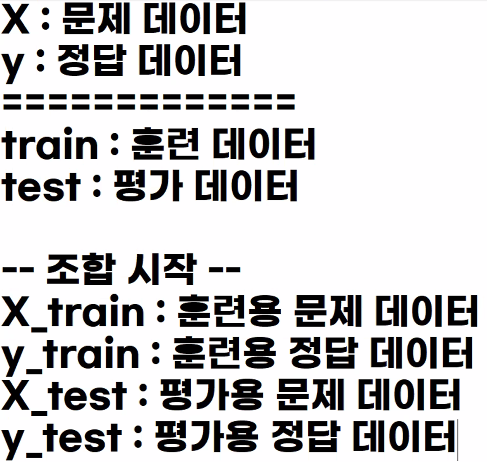

In [172]:
X_train.shape, X_test.shape, y_train.shape

((891, 8), (418, 8), (891,))

In [174]:
X_train

,Pclass,Sex,Age,Fare,Embarked,Deck,Family_Group,Title
PassengerId,,,,,,,,
1,3,male,22,7.2500,S,M,Small,Mr
2,1,female,38,71.2833,C,C,Small,Mrs
3,3,female,26,7.9250,S,M,Alone,Miss
4,1,female,35,53.1000,S,C,Small,Mrs
5,3,male,35,8.0500,S,M,Alone,Mr
...,...,...,...,...,...,...,...,...
887,2,male,27,13.0000,S,M,Alone,Rev
888,1,female,19,30.0000,S,B,Alone,Miss
889,3,female,21,23.4500,S,M,Small,Miss


In [ ]:
자료형이 문자형으로 된 녀석들을 one_hot 인코딩 해줘야함  문자형을 -> 숫자형으로

**문자형의 데이터를 원-핫 인코딩 진행**

- pd.get_dummies() 사용

In [176]:
# 원 - 핫 인코딩  
# get_dummies를 사용하면 문자형 데이터는 전부 원핫 인코딩이 진행 된다.
# 숫자 데이터는? 그대로 사용한다.

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [177]:
X_train.head()

,Pclass,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,...,Deck_T,Family_Group_Alone,Family_Group_Small,Family_Group_Large,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Title_Rev
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,3,22,7.2500,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
2,1,38,71.2833,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,3,26,7.9250,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
4,1,35,53.1000,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
5,3,35,8.0500,0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0


In [178]:
X_test.head()

,Pclass,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,...,Deck_M,Family_Group_Alone,Family_Group_Small,Family_Group_Large,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Title_Rev
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,3,34,7.8292,0,1,0,1,0,0,0,...,1,1,0,0,0,0,1,0,0,0
893,3,47,7.0000,1,0,0,0,1,0,0,...,1,0,1,0,0,0,0,1,0,0
894,2,62,9.6875,0,1,0,1,0,0,0,...,1,1,0,0,0,0,1,0,0,0
895,3,27,8.6625,0,1,0,0,1,0,0,...,1,1,0,0,0,0,1,0,0,0
896,3,22,12.2875,1,0,0,0,1,0,0,...,1,0,1,0,0,0,0,1,0,0


In [181]:
# info 함수로 확인하기 - X_train
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pclass              891 non-null    int64  
 1   Age                 891 non-null    int64  
 2   Fare                891 non-null    float64
 3   Sex_female          891 non-null    uint8  
 4   Sex_male            891 non-null    uint8  
 5   Embarked_C          891 non-null    uint8  
 6   Embarked_Q          891 non-null    uint8  
 7   Embarked_S          891 non-null    uint8  
 8   Deck_A              891 non-null    uint8  
 9   Deck_B              891 non-null    uint8  
 10  Deck_C              891 non-null    uint8  
 11  Deck_D              891 non-null    uint8  
 12  Deck_E              891 non-null    uint8  
 13  Deck_F              891 non-null    uint8  
 14  Deck_G              891 non-null    uint8  
 15  Deck_M              891 non-null    uint8  
 16  Deck_T  

In [182]:
# info 함수로 확인하기 - X_test
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pclass              418 non-null    int64  
 1   Age                 418 non-null    int64  
 2   Fare                418 non-null    float64
 3   Sex_female          418 non-null    uint8  
 4   Sex_male            418 non-null    uint8  
 5   Embarked_C          418 non-null    uint8  
 6   Embarked_Q          418 non-null    uint8  
 7   Embarked_S          418 non-null    uint8  
 8   Deck_A              418 non-null    uint8  
 9   Deck_B              418 non-null    uint8  
 10  Deck_C              418 non-null    uint8  
 11  Deck_D              418 non-null    uint8  
 12  Deck_E              418 non-null    uint8  
 13  Deck_F              418 non-null    uint8  
 14  Deck_G              418 non-null    uint8  
 15  Deck_M              418 non-null    uint8  
 16  Famil

In [185]:
# Shape
print(X_train.shape)
print(X_test.shape)

(891, 26)
(418, 25)


- 인코딩 이후에 X_train / X_test의 컬럼 수가 차이가 난다.

In [187]:
# set : 중복이 없는 요소들로만 구성된 집합의 형태로 바꿔주는 함수
set(X_train.columns) - set(X_test.columns)

{'Deck_T'}

In [189]:
# 불리언 인덱싱을 통해서 DECK 이 T인 사람이 누구인지 보자

train[train['Deck']=='T']

,Survived,Pclass,Sex,Age,Fare,Embarked,Deck,Family_Group,Title
PassengerId,,,,,,,,,
340,0,1,male,45,35.5,S,T,Alone,Mr


- Deck_T 라는 데이터는 train에 1개만 존재하는 데이터였다
- 원 핫 인코딩의 특성상 값이 존재하면 1 / 존재하지 않으면 0
- 그러면 test에는 Deck_T라는 데이터가 존재하지 않았다
- 0 으로 채워주자

In [190]:
X_test['Deck_T'] = 0

In [191]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pclass              418 non-null    int64  
 1   Age                 418 non-null    int64  
 2   Fare                418 non-null    float64
 3   Sex_female          418 non-null    uint8  
 4   Sex_male            418 non-null    uint8  
 5   Embarked_C          418 non-null    uint8  
 6   Embarked_Q          418 non-null    uint8  
 7   Embarked_S          418 non-null    uint8  
 8   Deck_A              418 non-null    uint8  
 9   Deck_B              418 non-null    uint8  
 10  Deck_C              418 non-null    uint8  
 11  Deck_D              418 non-null    uint8  
 12  Deck_E              418 non-null    uint8  
 13  Deck_F              418 non-null    uint8  
 14  Deck_G              418 non-null    uint8  
 15  Deck_M              418 non-null    uint8  
 16  Famil

In [193]:
# Deck_T를 추가해서 컬럼의 갯수를 맞춰줬다.
# 하지만 순서가 달라서 원활한 기계학습을 위해 순서까지 맞춰보자
X_train.columns

Index(['Pclass', 'Age', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_M', 'Deck_T', 'Family_Group_Alone',
       'Family_Group_Small', 'Family_Group_Large', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other', 'Title_Rev'],
      dtype='object')

In [197]:
# 컬럼 인덱싱 실험
X_train[['Pclass', 'Deck_C', 'Deck_G']]

,Pclass,Deck_C,Deck_G
PassengerId,,,
1,3,0,0
2,1,1,0
3,3,0,0
4,1,1,0
5,3,0,0
...,...,...,...
887,2,0,0
888,1,0,0
889,3,0,0


In [198]:
# test 컬럼 재배치
X_test= X_test[X_train.columns]

In [201]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pclass              418 non-null    int64  
 1   Age                 418 non-null    int64  
 2   Fare                418 non-null    float64
 3   Sex_female          418 non-null    uint8  
 4   Sex_male            418 non-null    uint8  
 5   Embarked_C          418 non-null    uint8  
 6   Embarked_Q          418 non-null    uint8  
 7   Embarked_S          418 non-null    uint8  
 8   Deck_A              418 non-null    uint8  
 9   Deck_B              418 non-null    uint8  
 10  Deck_C              418 non-null    uint8  
 11  Deck_D              418 non-null    uint8  
 12  Deck_E              418 non-null    uint8  
 13  Deck_F              418 non-null    uint8  
 14  Deck_G              418 non-null    uint8  
 15  Deck_M              418 non-null    uint8  
 16  Deck_

- 모델링을 위한 데이터 가공이 끝났다.
- 전처리가 잘 되어있어야 성능이 올라간다.

### 모델 선택
- KNN /DT 모델 사용해보기  

In [202]:
# KNN 모델
# 최근접 이웃 알고리즘 - 주변의 이웃의 값을 보고 새로운 데이터를 예측
# 이때 n_neighbors라는 하이퍼 파라미터를 조절해주는데 살펴볼 이웃의 갯수를 지정해주는 부분이다
# 어떤걸 가지고 이웃을 판별하는가? -> 거리  == 거리 기반 모델
# 모델 import 
from sklearn.neighbors import KNeighborsClassifier# KNN 분류 모델 살앗냐 죽어냐 



In [204]:
# 경고 무시 코드
import warnings
warnings.filterwarnings('ignore')

In [210]:
# 모델 객체 생성
# knn_ta_01이라는 변수에 주변 이웃값을 3개 살펴보는 knn 분류모델을 저장하세요
knn_ta_01 = KNeighborsClassifier(n_neighbors=3)

In [211]:
# 교차 검증 - cross_val_score

from sklearn.model_selection import cross_val_score

In [213]:
rs_knn_01 = cross_val_score(knn_ta_01, X_train, y_train, cv=5) # X_train, y_train cv=5 5번 으로 실행
rs_knn_01

array([0.7150838 , 0.70786517, 0.74719101, 0.75280899, 0.73033708])

In [214]:
rs_knn_01.mean()

0.7306572092147385

In [215]:
# 모델 학습  
knn_ta_01.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [217]:
# 모델 예측
pre = knn_ta_01.predict(X_test)
pre

array([0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [218]:
# kaggle 제출용 파일을 만들어 보자.
# 제출용 답안지 서식 불러오기
submission_knn01 = pd.read_csv('./data/gender_submission.csv')
submission_knn01

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [219]:
# 기존 답안지에 우리가 예측한 값을 덮어 씌우자
submission_knn01['Survived'] = pre

In [220]:
submission_knn01

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [221]:
# 수정한 데이터프레임을 파일로 만들어보자
submission_knn01.to_csv('knn_ta_01.csv', index=False)

1 . 문제 / 정답  

- 먼저 나누는 이유는 문제와 정답을 나누는 함수는 없으나 학습과 테스트 는 함수가   정의되어 있다

2. train/ test  train_test_split()


